Code for **super-resolution** (figures $1$ and $5$ from main paper).. Change `factor` to $8$ to reproduce images from fig. $9$ from supmat.

You can play with parameters and see how they affect the result. 

In [1]:
"""
*Uncomment if running on colab* 
Set Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab 
"""
# !git clone https://github.com/gmt1106/Image_Prior.git
# !mv Image_Prior/* ./

'\n*Uncomment if running on colab* \nSet Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab \n'

# Import libs

In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import argparse
import os

import numpy as np
from models import *

import torch
import torch.optim

## compare_psnr is renamed to peak_signal_noise_ratio
## from skimage.measure import compare_psnr
from skimage.metrics import peak_signal_noise_ratio
from models.downsampler import Downsampler

# use tensorboard with pytorch
from torch.utils.tensorboard import SummaryWriter

from utils.sr_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = None
if torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor
else:
    dtype = torch.FloatTensor

imsize = -1 
factor = 4 # 8
enforse_div32 = 'CROP' # we usually need the dimensions to be divisible by a power of two (32 in this case)
PLOT = True

# To produce images from the paper we took *_GT.png images from LapSRN viewer for corresponding factor,
# e.g. x4/zebra_GT.png for factor=4, and x8/zebra_GT.png for factor=8 
path_to_image = 'data/sr/zebra_GT.png'

# Load image 

HR and LR resolutions: (576, 384), (144, 96)


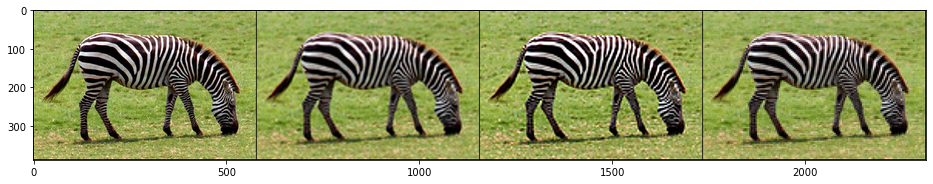

PSNR bicubic: 23.1048   PSNR nearest: 20.8212


In [3]:
# Starts here
imgs = load_LR_HR_imgs_sr(path_to_image , imsize, factor, enforse_div32)

imgs['bicubic_np'], imgs['sharp_np'], imgs['nearest_np'] = get_baselines(imgs['LR_pil'], imgs['HR_pil'])

if PLOT:
    plot_image_grid([imgs['HR_np'], imgs['bicubic_np'], imgs['sharp_np'], imgs['nearest_np']], 4,12);
    print ('PSNR bicubic: %.4f   PSNR nearest: %.4f' %  (
                                        peak_signal_noise_ratio(imgs['HR_np'], imgs['bicubic_np']), 
                                        peak_signal_noise_ratio(imgs['HR_np'], imgs['nearest_np'])))

# Set up

In [4]:
input_depth = 32
 
INPUT =     'noise'
pad   =     'reflection'
OPT_OVER =  'net'
KERNEL_TYPE='lanczos2'

LR = 0.01
tv_weight = 0.0

if factor == 4: 
    num_iter = 2000
    reg_noise_std = 0.03
elif factor == 8:
    num_iter = 4000
    reg_noise_std = 0.05
else:
    assert False, 'We did not experiment with other factors'

net = Net (
            input_depth, 3, 
            channels_down = [128, 128, 128, 128, 128],
            channels_up = [128, 128, 128, 128, 128],
            channels_skip = [4, 4, 4, 4, 4],
            filter_size_down = [3, 3, 3, 3, 3],
            filter_size_up = [3, 3, 3, 3, 3],
            upsample_mode = 'bilinear',
            need_sigmoid=True, need_bias=True, pad=pad)


# Train


In [5]:
net_input = get_noise(input_depth, INPUT, (imgs['HR_pil'].size[1], imgs['HR_pil'].size[0])).type(dtype).detach()

psnr_history = [] 
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
img_LR_var = np_to_torch(imgs['LR_np']).type(dtype)
downsampler = Downsampler(n_planes=3, factor=factor, kernel_type=KERNEL_TYPE, phase=0.5, preserve_size=True).type(dtype)


def train():
    global net_input

    # Create optimizier
    parameters = get_params(OPT_OVER, net, net_input)
    optimizer = torch.optim.Adam(parameters, lr=LR)

    # Loss
    loss = nn.MSELoss().type(dtype)    

    # tensorboard log directory 
    log_dir = "./logs/super_resolution/train"

    # Create summary writer
    writer = SummaryWriter(log_dir)

    # Create log directory and save directory if it does not exist
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)

    # Training loop
    for i in range(num_iter):

        if reg_noise_std > 0:
            net_input = net_input_saved + (noise.normal_() * reg_noise_std)

        # Apply the model to obtain scores (forward pass)
        out_HR = net.forward(net_input)
        out_LR = downsampler(out_HR)

        # Compute the loss 
        total_loss = loss(out_LR, img_LR_var)
        if tv_weight > 0:
            total_loss += tv_weight * tv_loss(out_HR)
        # Compute gradients    
        total_loss.backward()
        # Update parameters
        optimizer.step()
        # Zero the parameter gradients in the optimizer
        optimizer.zero_grad()

        # Log
        psnr_LR = peak_signal_noise_ratio(imgs['LR_np'], torch_to_np(out_LR))
        psnr_HR = peak_signal_noise_ratio(imgs['HR_np'], torch_to_np(out_HR))
        print ('Iteration %05d    PSNR_LR %.3f   PSNR_HR %.3f' % (i, psnr_LR, psnr_HR), '\r', end='')
                            
        # History
        psnr_history.append([psnr_LR, psnr_HR])

        # Image plot and monitor results
        if PLOT and i % 100 == 0:
            # Write output image to tensorboard, using keywords `image_output`
            writer.add_image("image_output", out_HR, global_step=i, dataformats='NCHW')
            # Write loss to tensorboard, using keywords `loss`
            writer.add_scalar("loss", total_loss, global_step=i)


train()

KeyboardInterrupt: 

# Result

In [ ]:
out_HR_np = np.clip(torch_to_np(net(net_input)), 0, 1)
result_deep_prior = put_in_center(out_HR_np, imgs['orig_np'].shape[1:])

# For the paper we acually took `_bicubic.png` files from LapSRN viewer and used `result_deep_prior` as our result
plot_image_grid([imgs['HR_np'],
                 imgs['bicubic_np'],
                 out_HR_np], factor=4, nrow=1);